In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from functools import reduce
from settings import settings
from joblib import Parallel, delayed

## Parameter Setting을 정의

In [2]:
save_path = Path("result")
data_path = Path("Data")

# Market Return

**변수 설명**
- `excntry`: ISO Alpha-3 코드로 표시된 증권이 상장된 국가.
- `eom`: 수익률을 계산하는 데 사용된 월의 월말.
- `characteristic`: 특성의 이름, Jensen, Kelly, Pedersen (2022)의 표 J.1을 참조.
- `region`: 포함된 팩터들의 지역/MSCI 국가 개발 상태.
- `size_grp`: 순위 가중 팩터를 생성하는 데 사용된 사이즈 그룹.
- `pf`: 포트폴리오 식별자.
- `n`: 포트폴리오 내의 총 주식 수.
- `n_stocks`: 롱(long) 및 숏(short) 포트폴리오 내의 총 주식 수.
- `n_stocks_min`: 롱 및 숏 포트폴리오 내 최소 주식 수. 예를 들어, 롱 포트폴리오에 10개의 주식이 있고 숏 포트폴리오에 40개의 주식이 있으면, `n_stocks=50`이고 `n_stocks_min=10`.
- `n_countries`: 지역 포트폴리오에 포함된 국가 수.
- `signal` (pfs.csv): 포트폴리오 내 중간 특성 값.
- `signal` (hml.csv, lms.csv): 롱 및 숏 포트폴리오 내 중간 특성의 차이.
- `signal_weighted`: 순위 가중 신호.
- `ret_ew`: 동등 가중 수익률.
- `ret_vw`: 가치 가중 수익률.
- `ret_vw_cap`: Jensen, Kelly, Pedersen (2022)에서 사용된 제한된 가치 가중 수익률.
- `ret_weighted`: 순위 가중 수익률.
- `me_lag1`: 월 초 기준으로 한 국가 내 총 시장 자본 규모.
- `dolvol_lag1`: 전월에 국가 내에서 거래된 총 거래 금액.
- `stocks`: 시장 포트폴리오에 포함된 주식.
- `mkt_vw_lcl`: 현지 통화로 표시된 가치 가중 시장 수익률.
- `mkt_ew_lcl`: 현지 통화로 표시된 동등 가중 시장 수익률.
- `mkt_vw`: USD로 표시된 가치 가중 시장 수익률.
- `mkt_ew`: USD로 표시된 동등 가중 시장 수익률.
- `mkt_ew_exc`: USD로 표시된 동등 가중 초과 시장 수익률.
- `mkt_vw_exc` (market_return.csv): USD로 표시된 가치 가중 초과 시장 수익률.
- `mkt_vw_exc` (Regional Factors): 지역 포트폴리오에 포함된 국가들의 USD로 표시된 가치 가중 평균 초과 시장 수익률.

In [3]:
market_returns = pd.read_csv(data_path / "market_returns.csv")

In [4]:
market_returns["eom"] = pd.to_datetime(market_returns["eom"])

In [5]:
market_returns.head()

,excntry,eom,stocks,me_lag1,dolvol_lag1,mkt_vw_lcl,mkt_ew_lcl,mkt_vw,mkt_ew,mkt_vw_exc,mkt_ew_exc
0,ARE,2001-06-30,6,1065.163770,NaN,-0.022455,-0.016860,-0.022463,-0.016856,-0.025241,-0.019634
1,ARE,2001-07-31,5,988.147326,NaN,0.024031,0.015455,0.024070,0.015487,0.021071,0.012488
2,ARE,2001-08-31,4,788.460280,NaN,0.031355,0.023716,0.031309,0.023671,0.028313,0.020675
3,ARE,2001-09-30,4,813.146492,NaN,0.026886,0.014666,0.026895,0.014677,0.024165,0.011947
4,ARE,2001-10-31,5,889.469208,NaN,-0.058416,-0.037733,-0.058421,-0.037739,-0.060575,-0.039893


**예상대로 market return은 Long-Only Market Return이다.**

<Axes: xlabel='eom'>

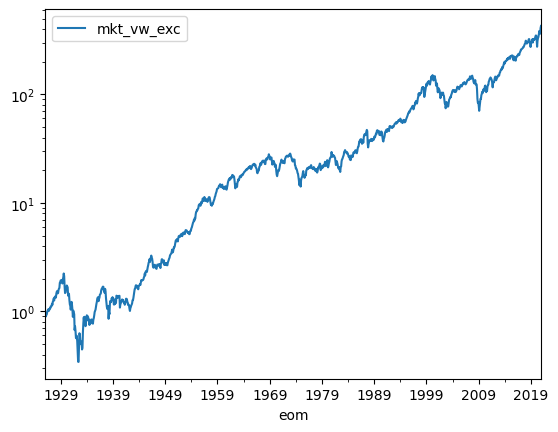

In [7]:
test_return = (
    market_returns[market_returns["excntry"] == "USA"]
    .loc[:, ["eom", "mkt_vw_exc"]]
    .set_index("eom")
)
test_return.add(1).cumprod().plot(logy=True)

In [7]:
market_returns = market_returns[
    (market_returns["eom"] >= settings["start_date"])
    & (market_returns["eom"] <= settings["end_date"])
    &
    # 데이터 문제로 제외할 국가들
    (~market_returns["excntry"].isin(settings["country_excl"]))
    & ~(
        (market_returns["excntry"] == "PER")
        & (market_returns["eom"] == pd.Timestamp("1992-01-31"))
        & (market_returns["mkt_vw_exc"] >= 8900)
    )
    & ~(
        (market_returns["excntry"] == "VEN")
        & (market_returns["eom"] == pd.Timestamp("2018-02-28"))
        & (market_returns["mkt_vw_exc"] < -1)
    )
]

## Labels

In [8]:
char_info = pd.read_excel(
    "Factor Details.xlsx", sheet_name="details", usecols="A:N"
).dropna(subset=["abr_jkp"])

In [ ]:
raise Exception()

In [ ]:
char_info = char_info[["abr_jkp", "direction", "in-sample period", "group"]].rename(
    columns={
        "abr_jkp": "characteristic",
        "in-sample period": "date_range",
        "group": "hxz_group",
    }
)
char_info["direction"] = char_info["direction"].astype(int)
char_info["sample_start"] = char_info["date_range"].str.extract(r"(^\d+)").astype(int)
char_info["sample_end"] = char_info["date_range"].str.extract(r"(\d+$)").astype(int)
# 각종 요인들 정의
base_chars = char_info["characteristic"].tolist()

# Country Classification

In [ ]:
country_classification = pd.read_excel(
    "Country Classification.xlsx", sheet_name="countries", usecols="A:C"
).dropna(subset=["excntry"])

In [ ]:
country_classification.head()

,excntry,msci_development,region
0,USA,developed,north america
1,CHN,emerging,asia
2,JPN,developed,asia
3,HKG,developed,asia
4,GBR,developed,europe


## Regions

In [ ]:
region_info = pd.DataFrame(
    {
        "name": ["us", "developed", "emerging", "frontier", "world", "world_ex_us"],
        "country_codes": [
            ["USA"],
            country_classification[
                country_classification["msci_development"] == "developed"
            ]["excntry"].tolist(),
            country_classification[
                country_classification["msci_development"] == "emerging"
            ]["excntry"].tolist(),
            country_classification[
                country_classification["msci_development"] == "frontier"
            ]["excntry"].tolist(),
            country_classification["excntry"].tolist(),
            country_classification[country_classification["excntry"] != "USA"][
                "excntry"
            ].tolist(),
        ],
        "countries_min": [1] + [settings["countries_min"]] * 3 + [1, 3],
    }
)

In [ ]:
region_info = region_info.set_index("name").to_dict("index")

In [ ]:
region_info.keys()

dict_keys(['us', 'developed', 'emerging', 'frontier', 'world', 'world_ex_us'])

## HML

In [ ]:
hml = pd.read_csv(data_path / "hml.csv")
hml["eom"] = pd.to_datetime(hml["eom"], format="%Y-%m-%d")

### Choose weighting

In [ ]:
# 나라별 portfolio weighting method 정한 것을 ret column으로 사용
hml_usa = hml[hml["excntry"] == "USA"].copy()
hml_usa.loc[:, "ret"] = hml_usa.loc[:, [f"ret_{settings['weighting']['us']}"]]

hml_ex_usa = hml[hml["excntry"] != "USA"].copy()
hml_ex_usa.loc[:, "ret"] = hml_ex_usa.loc[
    :, [f"ret_{settings['weighting']['global_ex_us']}"]
]

hml = pd.concat([hml_usa, hml_ex_usa])

In [ ]:
hml.head()

,excntry,characteristic,eom,signal,n_stocks,n_stocks_min,ret_ew,ret_vw,ret_vw_cap,ret
2050119,USA,age,1926-03-31,1.0,502,8,0.066167,0.098837,0.086738,0.086738
2050120,USA,age,1926-04-30,1.0,505,12,-0.010546,0.006303,0.000572,0.000572
2050121,USA,age,1926-05-31,2.0,510,17,0.020290,0.000190,0.006332,0.006332
2050122,USA,age,1926-06-30,2.0,512,21,0.008927,0.008323,0.003012,0.003012
2050123,USA,age,1926-07-31,2.0,503,23,-0.017724,0.004220,-0.003211,-0.003211


## Filter

In [ ]:
hml = hml[
    (hml["characteristic"].isin(base_chars))
    & (hml["eom"] >= settings["start_date"])
    & (hml["eom"] <= settings["end_date"])
    & (~hml["ret"].isna())
    & (hml["n_stocks_min"] >= settings["n_stocks_min"])
    & (~hml["excntry"].isin(settings["country_excl"]))
]

In [ ]:
hml = hml.drop(columns=["signal", "n_stocks_min"])

In [ ]:
hml.head()

,excntry,characteristic,eom,n_stocks,ret_ew,ret_vw,ret_vw_cap,ret
2050119,USA,age,1926-03-31,502,0.066167,0.098837,0.086738,0.086738
2050120,USA,age,1926-04-30,505,-0.010546,0.006303,0.000572,0.000572
2050121,USA,age,1926-05-31,510,0.020290,0.000190,0.006332,0.006332
2050122,USA,age,1926-06-30,512,0.008927,0.008323,0.003012,0.003012
2050123,USA,age,1926-07-31,503,-0.017724,0.004220,-0.003211,-0.003211


### Set direction as original study

In [ ]:
hml = hml.merge(
    char_info[["characteristic", "direction"]], on="characteristic", how="left"
)
hml["ret"] = hml["ret"] * hml["direction"]
hml = hml.drop(columns=["ret_vw", "ret_ew", "ret_vw_cap"])

데이터 중복 check

In [ ]:
if hml.duplicated(subset=["characteristic", "excntry", "eom"]).any():
    raise Exception("HML is duplicated")

## Regional Portfolios

In [ ]:
def regional_data(data, region, market_returns, countries, weighting, countries_min, months_min, size_grps=False):
    __market_returns = market_returns.copy()
    __data = data.copy()

    __weights = __market_returns[__market_returns["excntry"].isin(countries)].copy()
    # 총 시장 자본 규모로 정의
    __weights["country_weight"] = __weights.apply(
        lambda x: (
            x["me_lag1"]
            if weighting == "market_cap"
            else (x["stocks"] if weighting == "stocks" else 1)
        ),
        axis=1,
    )
    __pf = __data[__data["excntry"].isin(countries)].merge(
        __weights[["excntry", "eom", "country_weight", "mkt_vw_exc"]],
        on=["excntry", "eom"],
        how="left",
    )

    if size_grps:
        __pf = __pf.groupby(['characteristic', 'size_grp', 'eom']).agg(
            n=('ret', 'size'),
            ret=('ret', lambda x: np.average(x, weights=__pf.loc[x.index, 'country_weight'])),
            mkt_vw_exc=('mkt_vw_exc', lambda x: np.average(x, weights=__pf.loc[x.index, 'country_weight']))
        ).reset_index()
    else:
        __pf = (
            __pf.groupby(["characteristic", "eom"])
            .agg(
                n=("ret", "size"),
                # Country Return을 Country weight로 결합해서 선형 결합함
                ret=(
                    "ret",
                    lambda x: np.average(x, weights=__pf.loc[x.index, "country_weight"]),
                ),
                # USD 가충초과 수익률을 Return을 Country weight로 결합해서 선형 결합함
                mkt_vw_exc=(
                    "mkt_vw_exc",
                    lambda x: np.average(x, weights=__pf.loc[x.index, "country_weight"]),
                ),
            )
            .reset_index()
        )



    # 최소 국가 처리: Countries
    __pf = __pf[__pf['n'] >= countries_min]

    # Factor 수익률 기간 필터링
    __pf['months'] = __pf.groupby('characteristic')['eom'].transform('size')
    __pf = __pf[__pf['months'] >= months_min]
    __pf = __pf.assign(region=region)
    return __pf.copy()    

In [ ]:
iter_list = []
for key in tqdm(list(region_info.keys())):
    countries = region_info[key]["country_codes"]
    weighting = settings["country_weighting"]
    countries_min = region_info[key]["countries_min"]
    months_min = settings["months_min"]
    data = hml.copy()
    iter_list.append(
        {
            "data": hml.copy(),
            "region": key, 
            "market_returns": market_returns.copy(), 
            "countries": countries, 
            "weighting": weighting, 
            "countries_min": countries_min, 
            "months_min": months_min, 
        }
    )

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 11.28it/s]


In [ ]:
parallel = Parallel(n_jobs=8, verbose=True)

In [ ]:
region_pf_list = parallel(delayed(regional_data)(**i) for i in iter_list)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   26.8s finished


In [ ]:
regional_pfs = pd.concat(region_pf_list)

In [ ]:
regional_pfs.tail()

,characteristic,eom,n,ret,mkt_vw_exc,months,region
68826,zero_trades_252d,2020-08-31,51,-0.002759,0.045821,333,world_ex_us
68827,zero_trades_252d,2020-09-30,51,0.011594,-0.025302,333,world_ex_us
68828,zero_trades_252d,2020-10-31,51,0.010563,-0.011245,333,world_ex_us
68829,zero_trades_252d,2020-11-30,51,-0.036397,0.112102,333,world_ex_us
68830,zero_trades_252d,2020-12-31,51,-0.005676,0.051994,333,world_ex_us


In [ ]:
regional_pfs.to_parquet(save_path / "regional_pfs.parquet")

## Characteristic Managed Portfolios

In [ ]:
cmp = pd.read_csv(data_path / "cmp.csv")
cmp["eom"] = pd.to_datetime(cmp["eom"])

In [ ]:
cmp = cmp.rename(columns={'ret_weighted': 'ret'})
cmp = cmp[
    (cmp['characteristic'].isin(base_chars)) &
    (cmp['eom'] >= settings['start_date']) &
    (cmp['eom'] <= settings['end_date']) &
    (~cmp['ret'].isna()) &
    (cmp['signal_weighted'] != 0) &
    (cmp['n_stocks'] >= settings['n_stocks_min'] * 2) &
    (~cmp['excntry'].isin(settings['country_excl']))
]
cmp = cmp.drop(columns=['signal_weighted', 'n_stocks'])

In [ ]:
cmp = cmp.merge(char_info[['characteristic', 'direction']], on='characteristic', how='left')
cmp['ret'] = cmp['ret'] * cmp['direction']

In [ ]:
if cmp.duplicated(subset=['characteristic', 'excntry', 'size_grp', 'eom']).any():
    raise Warning("THE DATA HAS DUPLICATES")

In [ ]:
iter_list = []
for key in tqdm(list(region_info.keys())):
    countries = region_info[key]["country_codes"]
    weighting = settings["country_weighting"]
    countries_min = region_info[key]["countries_min"]
    months_min = settings["months_min"]
    data = hml.copy()
    iter_list.append(
        {
            "data": cmp.copy(),
            "region": key, 
            "market_returns": market_returns.copy(), 
            "countries": countries, 
            "weighting": weighting, 
            "countries_min": countries_min, 
            "months_min": months_min, 
            "size_grps": True, 
        }
    )

100%|██████████| 6/6 [00:00<00:00, 19.10it/s]


In [ ]:
regional_pfs_cmp_list = parallel(delayed(regional_data)(**i) for i in iter_list)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  1.8min finished


In [ ]:
regional_pfs_cmp = pd.concat(regional_pfs_cmp_list)

In [ ]:
regional_pfs_cmp.tail()

,characteristic,size_grp,eom,n,ret,mkt_vw_exc,months,region
656669,zero_trades_252d,small,2020-08-31,1,-0.004566,0.074068,5377,world
656670,zero_trades_252d,small,2020-09-30,1,-0.002624,-0.036228,5377,world
656671,zero_trades_252d,small,2020-10-31,1,0.025459,-0.020973,5377,world
656672,zero_trades_252d,small,2020-11-30,1,-0.130096,0.128030,5377,world
656673,zero_trades_252d,small,2020-12-31,1,-0.005767,0.046276,5377,world


In [ ]:
regional_pfs_cmp.to_parquet(save_path / "regional_pfs_cmp.parquet")

## Regional Market Returns

In [ ]:
regional_mkt_ret_list = []
for key in tqdm(list(region_info.keys())):
    countries = region_info[key]["country_codes"]
    weighting = settings["country_weighting"]
    countries_min = region_info[key]["countries_min"]
    months_min = settings["months_min"]

    __market_returns = market_returns.copy() 
    __pf = __market_returns[__market_returns["excntry"].isin(countries)].groupby('eom').agg(
        n=('mkt_vw_exc', 'size'),
        market=('mkt_vw_exc', lambda x: np.average(x, weights=market_returns.loc[x.index, 'me_lag1']))
    )
    __pf = __pf[__pf["n"] >= countries_min] 
    __pf = __pf.assign(region=key) 
    regional_mkt_ret_list.append(__pf)             

100%|██████████| 6/6 [00:00<00:00, 17.37it/s]


In [ ]:
regional_mkt_ret = pd.concat(regional_mkt_ret_list)

In [ ]:
regional_mkt_ret.tail()

,n,market,region
eom,,,
2020-08-31,90,0.045697,world_ex_us
2020-09-30,90,-0.025242,world_ex_us
2020-10-31,90,-0.011276,world_ex_us
2020-11-30,90,0.111943,world_ex_us
2020-12-31,90,0.052057,world_ex_us


In [ ]:
regional_mkt_ret.to_parquet(save_path / "regional_mkt_ret.parquet")